# Dataset
This notebook organize and divide [SCIELO](https://figshare.com/articles/A_Large_Parallel_Corpus_of_Full-Text_Scientific_Articles/5382757/2) dataset


# Import Cell

In [ ]:
! pip install langdetect 
! pip install swifter

In [2]:
from glob import glob
import os

import pandas as pd
import swifter

import numpy as np
from matplotlib import pyplot as plt 

from tqdm.notebook import tnrange, tqdm_notebook

import torch
from torch.distributions.multinomial import Multinomial
from torch.nn import CosineSimilarity
import torch.nn.functional as F
from langdetect import detect
from torchtext.vocab import GloVe
import string

%matplotlib inline

# Reading Scielo Dataset

Downloading data

In [ ]:
! wget -nc -O /work/datasets/scielo/scielo.tar.gz https://ndownloader.figshare.com/files/14019308
! tar -xzf /work/datasets/scielo/scielo.tar.gz

In [2]:
eng_scielo_path = "/work/datasets/scielo/en_pt.en"
pt_scielo_path = "/work/datasets/scielo/en_pt.pt"

eng_scielo = []
with open(eng_scielo_path, 'r') as file:
    eng_scielo = file.readlines()
    
pt_scielo = []
with open(pt_scielo_path, 'r') as file:
    pt_scielo = file.readlines()

In [3]:
eng_scielo[0]

'Albinism comes from the Latin albus, which meaning white, and is a group of hereditary disorders in which the biosynthesis of the pigment melanin is absent or reduced.\n'

In [4]:
pt_scielo[0]

'O albinismo, vem do latim albus, significa branco, é um grupo de desordens hereditárias em que a biossíntese do pigmento de melanina está ausente ou reduzida.\n'

## Analyzing Scielo Dataset with panda

In [5]:
scielo = pd.DataFrame((zip(eng_scielo, pt_scielo)), 
               columns =['ENG', 'PT']) 

In [6]:
scielo.describe()

,ENG,PT
count,2828916,2828916
unique,2493838,2488276
top,Introduction\n,Introdução\n
freq,8374,8387


In [7]:
# Removing duplicates
scielo = scielo.drop_duplicates(subset='ENG', keep="first")
scielo = scielo.drop_duplicates(subset='PT', keep="first")

In [8]:
scielo.describe()

,ENG,PT
count,2484173,2484173
unique,2484173,2484173
top,And he invited me to work with him.\n,"Assim como para o trabalho total, os grupos co..."
freq,1,1


In [9]:
# Checking length of each sentence on the dataset
scielo['ENG_LENGTH'] = scielo.apply( lambda row: len(row['ENG'].split()),axis=1)
scielo['PT_LENGTH']  = scielo.apply( lambda row: len(row['PT'].split()),axis=1)

In [10]:
# drop to small sentences (size < 30)
scielo = scielo.mask(scielo.ENG_LENGTH < 30 ).dropna()
scielo = scielo.mask(scielo.PT_LENGTH < 30 ).dropna()

In [11]:
scielo.describe()

,ENG_LENGTH,PT_LENGTH
count,817255.000000,817255.000000
mean,43.776996,44.287090
std,14.257965,14.350467
min,30.000000,30.000000
25%,34.000000,35.000000
50%,40.000000,40.000000
75%,48.000000,49.000000
max,522.000000,533.000000


In [12]:
# Remove sentence that are on another language
scielo['ENG_LANG'] = scielo.swifter.apply( lambda row: detect(row['ENG']) == 'en', axis=1)
scielo['PT_LANG']  = scielo.swifter.apply( lambda row: detect(row['PT']) == 'pt',axis=1)

In [13]:
# drop to wrong language assigned
scielo = scielo.mask(scielo.ENG_LANG == False ).dropna()
scielo = scielo.mask(scielo.PT_LANG == False ).dropna()

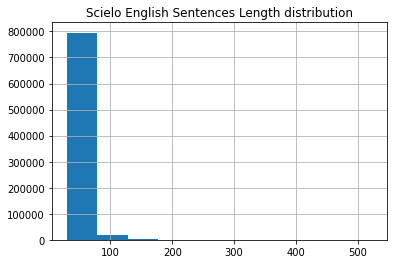

count    816471.000000
mean         43.772026
std          14.248244
min          30.000000
25%          34.000000
50%          40.000000
75%          48.000000
max         522.000000
Name: ENG_LENGTH, dtype: float64

In [14]:
scielo['ENG_LENGTH'].hist()
plt.title("Scielo English Sentences Length distribution")
plt.show()
scielo['ENG_LENGTH'].describe()

We can notice that 75% of the sentence has length less then 360

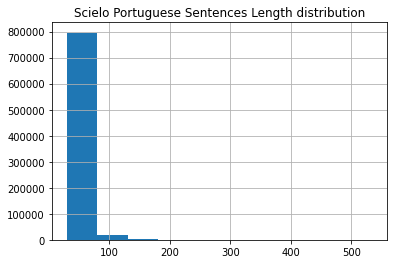

count    816471.000000
mean         44.283433
std          14.344414
min          30.000000
25%          35.000000
50%          40.000000
75%          49.000000
max         533.000000
Name: PT_LENGTH, dtype: float64

In [15]:
scielo['PT_LENGTH'].hist()
plt.title("Scielo Portuguese Sentences Length distribution")
plt.show()
scielo['PT_LENGTH'].describe()

In [ ]:
scielo.drop(['ENG_LENGTH','PT_LENGTH','ENG_LANG','PT_LANG'], axis=1, inplace=True)

In [ ]:
# Remove \n char from the end of each sentence
scielo = scielo.reset_index(drop=True)
scielo["ENG"] = scielo.apply( lambda row: row['ENG'].replace("\n",""),axis=1)
scielo["PT"] = scielo.apply( lambda row: row['PT'].replace("\n",""),axis=1)

In [24]:
# Save result dataframe to disk
scielo.to_pickle("/work/datasets/scielo/full_organized_data.pkcl")

# Creating Dataset with Negative Samples
In this section we will compare each English sentence embedding with each pt sentence embedding, using cosine similarity.
After this we will retrieve the top-5 similar sentence of each, notice that we expect that just lexical similarity will be retrieve, this is why we are using a simple model of GloVe to make this comparison.

The Idea is select the most lexical similar sentence from one language to another, but with a very different semantic.

In [52]:
# load Dataset
dataset = pd.read_pickle('/work/datasets/scielo/full_organized_data.pkcl')

In [53]:
dataset.describe()

,ENG,PT
count,816471,816471
unique,816471,816471
top,"In the past, we did not perform insufflation w...","Em última análise, a convergência entre nature..."
freq,1,1


### Loading Glove Vectors to use as word embedding

In [4]:

# glove_vectors is a pytorch vocabulary
# https://github.com/pytorch/text/blob/master/torchtext/vocab.py
glove_vectors = GloVe(name='6B', dim=50, cache='./glove_dir')

vectors = glove_vectors.vectors
glove_dict = glove_vectors.stoi

### Creating Torch Tensors from the words

In [5]:
eng_data  = dataset["ENG"].values
pt_data  = dataset["PT"].values

## Making Embedding with the sentence 
We just remove the punctuation of the sentence for the embedding

In [6]:
table = str.maketrans({key: None for key in string.punctuation})
def remove_punctuation(sentence):
    return sentence.translate(table)

def get_sentence_embedding(sentence,dim=50):
    """
    From a input sentence, calculate a sentence embedding.
    The sentence embedding is the mean of each word embedding beloging to the sentence.
    """
    
    # Remove punctuation from the sentence
    sentence = remove_punctuation(sentence)
    
    # Calculate the mean for each word embedding beloging to the sentence
    list_of_embedding =  [ vectors[glove_dict[word]] 
                             for word in sentence.split()
                             if (word in glove_dict)
                         ]
    
    # if we could not find any word in the sentence that is in the vocabulary
    # we return a random value
    if list_of_embedding == []:
        print("FALSE")
        return torch.rand(dim)
        
    # return the sentence embedding mean
    return torch.mean( torch.stack( list_of_embedding) ,axis=0)

In [7]:
eng_vectors = []
for sentence in tqdm_notebook(eng_data):
    eng_vectors.append(get_sentence_embedding(sentence))
eng_vectors = torch.stack(eng_vectors)

In [8]:
pt_vectors = []
for sentence in tqdm_notebook(pt_data):
    pt_vectors.append(get_sentence_embedding(sentence))
pt_vectors = torch.stack(pt_vectors)

FALSE



# Testset
the most similars are retrieved by top_k

In [10]:

cos = CosineSimilarity()
def find_most_similar(query, tensors,index,top_k=200):
    """
    Retrieve most similar sentences
    """
    # Reshape query 
    query = query.unsqueeze(0)
    # Apply cosine similarity between the query and all dataset
    cosine_similarity_between_query_tensors = cos(query,tensors)
    
    # Sort values by similarity: The highest similarity is 1 and lowest -1
    values, indeces = cosine_similarity_between_query_tensors.topk(top_k)
    
    # Get Random sentence that are inside the nucleues
    sampling = Multinomial(total_count=10,logits=values).sample()
    
    # Retrieve selected sentence
    most_similar = indeces.masked_select(sampling.type(torch.bool))
    # remove the translation of the query from the selected ones ( if it is there)
    most_similar = most_similar[most_similar != index]
    
    # Return the top_5 similar result, after the sampling
    return most_similar[:5]

In [ ]:
negative_sentence = {
    'top_1_qeng_pt': [],
    'top_1_qpt_eng': [],
    'top_2_qeng_pt': [],
    'top_2_qpt_eng': [],
    'top_3_qeng_pt': [],
    'top_3_qpt_eng': [],
    'top_4_qeng_pt': [],
    'top_4_qpt_eng': [],
    'top_5_qeng_pt': [],
    'top_5_qpt_eng': []
}
total = len(dataset)
for index,(eng,pt) in tqdm_notebook(dataset.iterrows(),total=total):
    
    # Most lexical similar senentece from pt to eng
    qpt_index = find_most_similar(pt_vectors[index],eng_vectors,index)
    top1,top2,top3,top4,top5 = qpt_index #dataset.ENG.iloc[qpt_index].values
    
    negative_sentence['top_1_qpt_eng'].append(top1.item())
    negative_sentence['top_2_qpt_eng'].append(top2.item())
    negative_sentence['top_3_qpt_eng'].append(top3.item())
    negative_sentence['top_4_qpt_eng'].append(top4.item())
    negative_sentence['top_5_qpt_eng'].append(top5.item())
    
    # Most lexical similar senentece from eng to pt
    qeng_index = find_most_similar(eng_vectors[index],pt_vectors,index)
    top1,top2,top3,top4,top5 = qeng_index #dataset.PT.iloc[qeng_index].values
    
    negative_sentence['top_1_qeng_pt'].append(top1.item())
    negative_sentence['top_2_qeng_pt'].append(top2.item())
    negative_sentence['top_3_qeng_pt'].append(top3.item())
    negative_sentence['top_4_qeng_pt'].append(top4.item())
    negative_sentence['top_5_qeng_pt'].append(top5.item())
    
    with open("/work/datasets/scielo/top_k_dataset_status.txt","w") as file:
        file.write(f"{index}/{total}")
        
dataset['top_1_qpt_eng'] = negative_sentence['top_1_qpt_eng']
dataset['top_2_qpt_eng'] = negative_sentence['top_2_qpt_eng']
dataset['top_3_qpt_eng'] = negative_sentence['top_3_qpt_eng']
dataset['top_4_qpt_eng'] = negative_sentence['top_4_qpt_eng']
dataset['top_5_qpt_eng'] = negative_sentence['top_5_qpt_eng']

dataset['top_1_qeng_pt'] = negative_sentence['top_1_qeng_pt']
dataset['top_2_qeng_pt'] = negative_sentence['top_2_qeng_pt']
dataset['top_3_qeng_pt'] = negative_sentence['top_3_qeng_pt']
dataset['top_4_qeng_pt'] = negative_sentence['top_4_qeng_pt']
dataset['top_5_qeng_pt'] = negative_sentence['top_5_qeng_pt']

# Save dataset on disk
dataset.to_pickle("/work/datasets/scielo/top_k_dataset.pkcl")
with open("/work/datasets/scielo/top_k_dataset_status.txt","w") as file:
        file.write("Done --- ")

In [3]:
dataset = pd.read_pickle("/work/datasets/scielo/top_k_dataset.pkcl")

In [5]:
# Removing duplicates

testset = pd.DataFrame()

testset = testset.append(dataset.drop_duplicates(subset='top_1_qeng_pt', keep="first"))

testset = testset.append(dataset.drop_duplicates(subset='top_2_qeng_pt', keep="first"))

testset = testset.append(dataset.drop_duplicates(subset='top_3_qeng_pt', keep="first"))

testset = testset.append(dataset.drop_duplicates(subset='top_4_qeng_pt', keep="first"))

testset = testset.append(dataset.drop_duplicates(subset='top_5_qeng_pt', keep="first"))

testset = testset.append(dataset.drop_duplicates(subset='top_1_qpt_eng', keep="first"))

testset = testset.append(dataset.drop_duplicates(subset='top_2_qpt_eng', keep="first"))

testset = testset.append(dataset.drop_duplicates(subset='top_3_qpt_eng', keep="first"))

testset = testset.append(dataset.drop_duplicates(subset='top_4_qpt_eng', keep="first"))

testset = testset.append(dataset.drop_duplicates(subset='top_5_qpt_eng', keep="first"))


In [6]:
testset = testset.drop_duplicates(subset='ENG', keep="first")
testset = testset.drop_duplicates(subset='PT', keep="first")

In [7]:
len(testset)

9956

In [10]:
from tqdm import tqdm_notebook
for test_index, row in tqdm_notebook(enumerate(testset.iterrows()),total=len(testset )):
    index = row[0]
    
    testset.top_1_qpt_eng.iloc[test_index] = dataset.ENG.iloc[dataset.top_1_qpt_eng.iloc[index]]
    testset.top_2_qpt_eng.iloc[test_index] = dataset.ENG.iloc[dataset.top_2_qpt_eng.iloc[index]]
    testset.top_3_qpt_eng.iloc[test_index] = dataset.ENG.iloc[dataset.top_3_qpt_eng.iloc[index]]
    testset.top_4_qpt_eng.iloc[test_index] = dataset.ENG.iloc[dataset.top_4_qpt_eng.iloc[index]]
    testset.top_5_qpt_eng.iloc[test_index] = dataset.ENG.iloc[dataset.top_5_qpt_eng.iloc[index]]
    testset.top_1_qeng_pt.iloc[test_index] = dataset.PT.iloc[dataset.top_1_qeng_pt.iloc[index]]
    testset.top_2_qeng_pt.iloc[test_index] = dataset.PT.iloc[dataset.top_2_qeng_pt.iloc[index]]
    testset.top_3_qeng_pt.iloc[test_index] = dataset.PT.iloc[dataset.top_3_qeng_pt.iloc[index]]
    testset.top_4_qeng_pt.iloc[test_index] = dataset.PT.iloc[dataset.top_4_qeng_pt.iloc[index]]
    testset.top_5_qeng_pt.iloc[test_index] = dataset.PT.iloc[dataset.top_5_qeng_pt.iloc[index]]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [ ]:
testset.to_pickle("/work/datasets/scielo/test_set_with_negatives_strings.pkcl")

In [12]:
testset.describe()

,ENG,PT,top_1_qpt_eng,top_2_qpt_eng,top_3_qpt_eng,top_4_qpt_eng,top_5_qpt_eng,top_1_qeng_pt,top_2_qeng_pt,top_3_qeng_pt,top_4_qeng_pt,top_5_qeng_pt
count,9956,9956,9956,9956,9956,9956,9956,9956,9956,9956,9956,9956
unique,9956,9956,1358,1737,2027,2235,2494,1108,1379,1564,1773,1954
top,The possible diagnoses included silent myocard...,"Neste contexto de parada cardiorrespiratória, ...","In 1492, the year that Christopher Columbus la...","The research ""Acesso dos imigrantes bolivianos...",This study is part of the database of the proj...,Commerce was the exclusive prerogative of citi...,"La Mode said that, at the show, ""le roi de Por...","Foram obedecidas, também, as normas estabeleci...","Neste contexto, considerando-se a utilização d...",Considerou-se o volume sistólico final normal ...,Para estabelecer a gravidade global dos pacien...,Foram utilizados os instrumentos: formulário s...
freq,1,1,276,105,67,57,46,275,106,69,58,54


# Trainset
the most similars are retrieved by top_p (based on Nuclueos Sampling)

In [ ]:
cos = CosineSimilarity()


def find_most_similar(query, tensors,index,top_p=0.8,minimum_sampling_size=500):
    
     
    query = query.unsqueeze(0)
    cosine_similarity_between_query_tensors = cos(query,tensors)
    
    
    sorted_values, indices_values = torch.sort(cosine_similarity_between_query_tensors,descending=True)
    
    
    out_of_sampling_indeces = indices_values.new_ones(indices_values.shape).type(torch.bool)
    sorted_probs = F.softmax(sorted_values, dim=-1)
    
    cumulated_probs = torch.cumsum(sorted_probs,dim=-1)
    out_of_sampling_indeces[ cumulated_probs < top_p ] = False
    out_of_sampling_indeces[... , : minimum_sampling_size] = False
    sorted_probs[out_of_sampling_indeces] = 0
    
    sampling = Multinomial(total_count=10,probs=sorted_probs).sample()
    
    most_similar = indices_values.masked_select(sampling.type(torch.bool))
    most_similar = most_similar[most_similar != index]
    return most_similar[:5]

In [ ]:
negative_sentence = {
    'top_1_qeng_pt': [],
    'top_1_qpt_eng': [],
    'top_2_qeng_pt': [],
    'top_2_qpt_eng': [],
    'top_3_qeng_pt': [],
    'top_3_qpt_eng': [],
    'top_4_qeng_pt': [],
    'top_4_qpt_eng': [],
    'top_5_qeng_pt': [],
    'top_5_qpt_eng': []
}
total = len(dataset)
for index,(eng,pt) in dataset.iterrows():
    
    # Most lexical similar senentece from pt to eng
    qpt_index = find_most_similar(pt_vectors[index],eng_vectors,index)
    top1,top2,top3,top4,top5 = qpt_index #dataset.ENG.iloc[qpt_index].values
    
    negative_sentence['top_1_qpt_eng'].append(top1.item())
    negative_sentence['top_2_qpt_eng'].append(top2.item())
    negative_sentence['top_3_qpt_eng'].append(top3.item())
    negative_sentence['top_4_qpt_eng'].append(top4.item())
    negative_sentence['top_5_qpt_eng'].append(top5.item())
    
    # Most lexical similar senentece from eng to pt
    qeng_index = find_most_similar(eng_vectors[index],pt_vectors,index)
    top1,top2,top3,top4,top5 = qeng_index #dataset.PT.iloc[qeng_index].values
    
    negative_sentence['top_1_qeng_pt'].append(top1.item())
    negative_sentence['top_2_qeng_pt'].append(top2.item())
    negative_sentence['top_3_qeng_pt'].append(top3.item())
    negative_sentence['top_4_qeng_pt'].append(top4.item())
    negative_sentence['top_5_qeng_pt'].append(top5.item())
    
    with open("datasets/scielo/full_construction_status.txt","w") as file:
        file.write(f"{index}/{total}")
        
dataset['top_1_qpt_eng'] = negative_sentence['top_1_qpt_eng']
dataset['top_2_qpt_eng'] = negative_sentence['top_2_qpt_eng']
dataset['top_3_qpt_eng'] = negative_sentence['top_3_qpt_eng']
dataset['top_4_qpt_eng'] = negative_sentence['top_4_qpt_eng']
dataset['top_5_qpt_eng'] = negative_sentence['top_5_qpt_eng']

dataset['top_1_qeng_pt'] = negative_sentence['top_1_qeng_pt']
dataset['top_2_qeng_pt'] = negative_sentence['top_2_qeng_pt']
dataset['top_3_qeng_pt'] = negative_sentence['top_3_qeng_pt']
dataset['top_4_qeng_pt'] = negative_sentence['top_4_qeng_pt']
dataset['top_5_qeng_pt'] = negative_sentence['top_5_qeng_pt']

dataset.to_pickle("datasets/scielo/full_data_with_negatives.pkcl")
with open("datasets/scielo/full_construction_status.txt","w") as file:
        file.write("Done --- ")

In [ ]:
dataset = pd.read_pickle("/work/datasets/scielo/full_data_with_negatives.pkcl")
for row in tqdm_notebook(dataset.iterrows(),total=len(dataset )):
    index = row[0]
    
    dataset.top_1_qpt_eng.iloc[index] = dataset.ENG.iloc[dataset.top_1_qpt_eng.iloc[index]]
    dataset.top_2_qpt_eng.iloc[index] = dataset.ENG.iloc[dataset.top_2_qpt_eng.iloc[index]]
    dataset.top_3_qpt_eng.iloc[index] = dataset.ENG.iloc[dataset.top_3_qpt_eng.iloc[index]]
    dataset.top_4_qpt_eng.iloc[index] = dataset.ENG.iloc[dataset.top_4_qpt_eng.iloc[index]]
    dataset.top_5_qpt_eng.iloc[index] = dataset.ENG.iloc[dataset.top_5_qpt_eng.iloc[index]]
    dataset.top_1_qeng_pt.iloc[index] = dataset.PT.iloc[dataset.top_1_qeng_pt.iloc[index]]
    dataset.top_2_qeng_pt.iloc[index] = dataset.PT.iloc[dataset.top_2_qeng_pt.iloc[index]]
    dataset.top_3_qeng_pt.iloc[index] = dataset.PT.iloc[dataset.top_3_qeng_pt.iloc[index]]
    dataset.top_4_qeng_pt.iloc[index] = dataset.PT.iloc[dataset.top_4_qeng_pt.iloc[index]]
    dataset.top_5_qeng_pt.iloc[index] = dataset.PT.iloc[dataset.top_5_qeng_pt.iloc[index]]
    
dataset.to_pickle("/work/datasets/scielo/full_data_with_negatives_strings.pkcl")


In [35]:
TRAIN_DATA = pd.read_pickle("/work/datasets/scielo/full_data_with_negatives_strings.pkcl")

In [36]:
TRAIN_DATA.describe()

,ENG,PT,top_1_qpt_eng,top_2_qpt_eng,top_3_qpt_eng,top_4_qpt_eng,top_5_qpt_eng,top_1_qeng_pt,top_2_qeng_pt,top_3_qeng_pt,top_4_qeng_pt,top_5_qeng_pt
count,816471,816471,816471,816471,816471,816471,816471,816471,816471,816471,816471,816471
unique,816471,816471,240027,331200,381324,410643,426533,164080,236628,283497,312654,329689
top,"In the past, we did not perform insufflation w...","Em última análise, a convergência entre nature...","MD, Boston University; Reader Immunology, Univ...",In many patients this was the only definite tr...,"In 15, the conditional construction has the pr...",The performance of the students from this stud...,Most of the previous reports have used clinica...,Dentre as demais variáveis testadas na análise...,"No Brasil, a disponibilidade domiciliar de fru...","Contudo, como ambas as universidades ocupam as...","Logo, acreditamos que esses fatores podem ter ...",Os distúrbios de leitura e escrita encontram-s...
freq,1,1,35,16,14,12,11,35,20,16,14,13


### Remove from TRAIN_DATA the samples that are in testset

In [37]:
len(TRAIN_DATA)

816471

In [43]:
TRAIN_DATA = TRAIN_DATA.drop(index=testset.index)

In [44]:
len(TRAIN_DATA)

806515

In [45]:
TRAIN_DATA.to_pickle("/work/datasets/scielo/TRAINSET_with_negatives_strings.pckl")

# Conclusions and Stats

In [50]:
## TESTSET
testset.describe()

,ENG,PT,top_1_qpt_eng,top_2_qpt_eng,top_3_qpt_eng,top_4_qpt_eng,top_5_qpt_eng,top_1_qeng_pt,top_2_qeng_pt,top_3_qeng_pt,top_4_qeng_pt,top_5_qeng_pt
count,9956,9956,9956,9956,9956,9956,9956,9956,9956,9956,9956,9956
unique,9956,9956,1358,1737,2027,2235,2494,1108,1379,1564,1773,1954
top,The possible diagnoses included silent myocard...,"Neste contexto de parada cardiorrespiratória, ...","In 1492, the year that Christopher Columbus la...","The research ""Acesso dos imigrantes bolivianos...",This study is part of the database of the proj...,Commerce was the exclusive prerogative of citi...,"La Mode said that, at the show, ""le roi de Por...","Foram obedecidas, também, as normas estabeleci...","Neste contexto, considerando-se a utilização d...",Considerou-se o volume sistólico final normal ...,Para estabelecer a gravidade global dos pacien...,Foram utilizados os instrumentos: formulário s...
freq,1,1,276,105,67,57,46,275,106,69,58,54


In [51]:
# Trainset
TRAIN_DATA.describe()

,ENG,PT,top_1_qpt_eng,top_2_qpt_eng,top_3_qpt_eng,top_4_qpt_eng,top_5_qpt_eng,top_1_qeng_pt,top_2_qeng_pt,top_3_qeng_pt,top_4_qeng_pt,top_5_qeng_pt
count,806515,806515,806515,806515,806515,806515,806515,806515,806515,806515,806515,806515
unique,806515,806515,237590,328340,378180,407336,423166,163229,235504,282165,311014,327881
top,The high-resolution ECG HRECG is a useful tool...,O confinamento revelou-se mais difícil para as...,"MD, Boston University; Reader Immunology, Univ...",In many patients this was the only definite tr...,"In 15, the conditional construction has the pr...",The performance of the students from this stud...,Future studies should be conducted in order to...,Os princípios do modelo científico para compre...,"No Brasil, a disponibilidade domiciliar de fru...","Contudo, como ambas as universidades ocupam as...","Após o ensaio clínico, no grupo vitamina D, a ...","Estudos recentes mostram que, para pacientes p..."
freq,1,1,35,16,14,12,11,35,20,16,14,13


The testset has few data, but its data is lexically similar to the 'ENG'/'PT' sentence
On the other hand, TRAIN_DATA has much more data, with this similarity relaxed, to have more diversity between the query 'ENG'/'PT' and the retrieved sentences.